# Esercizio 11.1

Utilizzo una rete neruale per fare regressione lineare della funzione 
$$
f(x)=1+2x
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


In [2]:
m=2
b=1
N_valid=50
def Generate_Data(N_train, sigma):
  #np.random.seed(0)
  x_train = np.random.uniform(-1, 1, N_train)   #random points in -1,1
  x_valid = np.random.uniform(-1, 1, N_valid)   #""
  x_valid.sort()
  y_target = m * x_valid + b # ideal (target) linear function
  y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
  y_valid = np.random.normal(m * x_valid + b, sigma) #""
  data={
      "x_train": x_train,
      "y_train": y_train,
      "x_valid": x_valid,
      "y_valid": y_valid,
      "y_target": y_target
       }
  return data

In [3]:
def NN_test(N_train=500,N_epoch=30, sigma=0, N_valid=50):
  model = tf.keras.Sequential()
  model.add(Dense(1, input_shape=(1,)))
  model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
  data=Generate_Data(N_train, sigma)
  history = model.fit(x=data["x_train"], y=data["y_train"], 
          batch_size=32, epochs=N_epoch,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(data["x_valid"], data["y_valid"]))

  # evaluate
  score = model.evaluate(data["x_valid"], data["y_valid"], batch_size=32, verbose=1)
  score_ec = model.evaluate(data["x_valid"], data["y_target"], batch_size=32, verbose=1)

  # print performance
  print()
  print('Test loss:   data_test=', score[0], "  exact curve=", score_ec[0])
  print('Test accuracy:   data_test=', score[1], "  exact curve=", score_ec[1])

  return([data,history,score[0],score_ec[0], model])

------------------
Parametri standard per primo test


In [ ]:
N_train_std=1000
N_epoch_std=80
sigma_std=0

md(f"First test with standard parameter: N_train={N_train_std} N_epoch={N_epoch_std}, sigma={sigma_std}")

First test with standard parameter: N_train=1000 N_epoch=80, sigma=0

In [ ]:
data,history,loss_std,loss_ec_std, model=NN_test(N_train_std, N_epoch_std, sigma_std)

Epoch 1/80
32/32 [==============================] - 0s 5ms/step - loss: 1.0226 - mse: 1.0226 - val_loss: 0.6058 - val_mse: 0.6058
Epoch 2/80
32/32 [==============================] - 0s 2ms/step - loss: 0.4746 - mse: 0.4746 - val_loss: 0.3044 - val_mse: 0.3044
Epoch 3/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2556 - mse: 0.2556 - val_loss: 0.1735 - val_mse: 0.1735
Epoch 4/80
32/32 [==============================] - 0s 2ms/step - loss: 0.1515 - mse: 0.1515 - val_loss: 0.1065 - val_mse: 0.1065
Epoch 5/80
32/32 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0947 - val_loss: 0.0676 - val_mse: 0.0676
Epoch 6/80
32/32 [==============================] - 0s 2ms/step - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0435 - val_mse: 0.0435
Epoch 7/80
32/32 [==============================] - 0s 2ms/step - loss: 0.0391 - mse: 0.0391 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 8/80
32/32 [==============================] - 0s 2ms/step - loss: 0.0253 - mse: 0.02

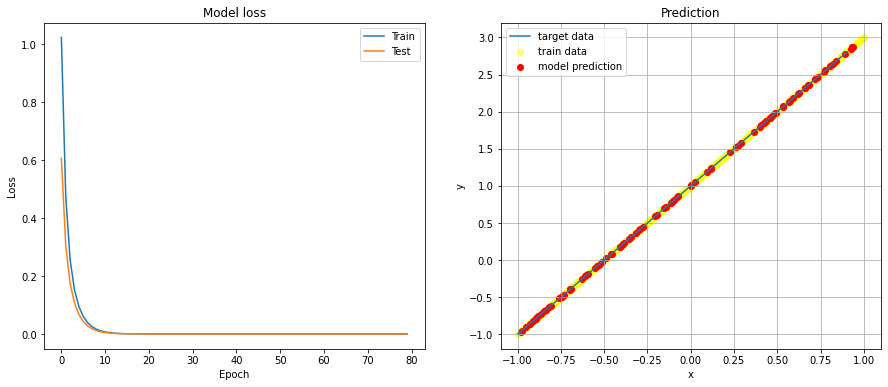

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)[0:,0]
ax[1].scatter(data["x_train"], data["y_train"], alpha=0.5,color="yellow", label="train data")
ax[1].scatter(x_predicted, y_predicted,color='r', label="model prediction")
ax[1].plot(data["x_valid"], data["y_target"], label="target data")
ax[1].set_title('Prediction')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].legend()
ax[1].grid(True)


The neural network seems to be able to make almost a perfect regression. Note also that beacuse of the zero Gaussian noise ($\sigma=0$) the loss esteem for theoretical data and validation data are the same

-------------------------------------

### Testin NN for different values of $N_{train}$, $N_{valid}$ and $\sigma$

In [6]:
N_trains=np.arange(100,1400, 200 )
N_epochs=np.arange(20, 80, 10)  
sigmas=np.array([0,0.1,0.6, 1])

In [7]:
#defining a few functions to simplify the job later on
v=["N_train","N_epoch","sigmas", "loss_VD", "loss_EC"]

def Find_best_NN(sigma):
  '''
  Input=sigma
  Test the neural network for different values of N_train and N_epochs for a defined value of sigma
  and give in output al the training values and the best NN 
  Output= TEST : list of all values relative the test
          history: history of the best NN run
          data: all data relative to values of the best run 
          model: best NN model
  '''
  TEST=pd.DataFrame(columns=v)
  for N_train in N_trains:
    losses_EC=np.zeros(len(N_epochs))
    losses_VD=np.zeros(len(N_epochs))

    i=0
    for N_epoch in N_epochs:
      data,history, test_loss, loss_ec, model=NN_test(N_train, N_epoch, sigma)
      losses_VD[i]=test_loss
      losses_EC[i]=loss_ec

      i=i+1
      if(N_epoch==N_epochs[0] and N_train==N_trains[0]):
        N_train_best=N_train
        N_epoch_best=N_epoch
        data_best=data 
        history_best=history 
        model_best=model
        loss_check=test_loss

      if test_loss<loss_check:
        N_train_best=N_train
        N_epoch_best=N_epoch
        data_best=data 
        history_best=history 
        loss_check=test_loss
        model_best=model
  
    TEST.loc[len(TEST.index)] = [N_train, N_epochs, sigma, losses_VD, losses_EC]
  return TEST, history_best, data_best, model_best


def best_TEST_results(TEST):
    '''
    input: NN data
    output: best values (based on loss) for different N_train
    '''
    print("best values for different N:train")
    print( "{:<10} {:<10} {:<21} {:<21}".format("N_train=", "N_epoch", "loss validation data", "loss exact curve"))

    for N_train in N_trains:
      test_loss=TEST.loc[TEST["N_train"]==N_train, "loss_VD"].to_numpy()[0]
      test_loss_ec=TEST.loc[TEST["N_train"]==N_train, "loss_EC"].to_numpy()[0]
      N_valid=TEST.loc[TEST["N_train"]==N_train, "N_epoch"].to_numpy()[0]
      print( "{:<10} {:<10} {:<21} {:<21}".format(N_train, N_epochs[np.argmin(test_loss)], np.min(test_loss),test_loss_ec[np.argmin(test_loss)]))


def plot_NN(history, data, model):
  '''
  Plot history and fit for a neural network
  '''
  fig,ax=plt.subplots(1,2,figsize=(15,6))
  ax[0].plot(history.history['loss'])
  ax[0].plot(history.history['val_loss'])
  ax[0].set_title('Model loss')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Test'], loc='best')
  ax[0].grid(True)

  x_predicted = np.random.uniform(-1, 1, 100)
  y_predicted = model.predict(x_predicted)[0:,0]
  ax[1].scatter(data["x_train"], data["y_train"], alpha=0.5,color="yellow", label="train data")
  ax[1].scatter(x_predicted, y_predicted,color='r', label="model prediction")
  ax[1].set_title('Prediction')
  ax[1].plot(data["x_valid"], data["y_target"], label="target data")
  ax[1].set_xlabel("x")
  ax[1].set_ylabel("y")
  ax[1].legend()
  ax[1].grid(True)


def plot_grid(TEST):
  Loss_VD=np.zeros( (len(N_trains),len(N_epochs) ))
  Loss_EC=np.zeros( (len(N_trains),len(N_epochs) ))

  i=0
  for N_train in N_trains:
      Loss_VD[i]=TEST.loc[TEST["N_train"]==N_train, 'loss_VD'].to_numpy()[0]
      Loss_EC[i]=TEST.loc[TEST["N_train"]==N_train, 'loss_EC'].to_numpy()[0]
      i=i+1
  plt.figure(figsize=(12,5))
  extent =np.min(N_epochs), np.max(N_epochs),np.max(N_trains), np.min(N_trains)

  plt.subplot(121)
  plt.imshow(Loss_VD, extent=extent,aspect= np.max(N_epochs)/np.max(N_trains))
  plt.title("validation data loss")
  plt.xlabel("# pochs")
  plt.ylabel("# trains")
  plt.colorbar()


  plt.subplot(122)
  plt.imshow(Loss_EC, extent=extent,aspect= np.max(N_epochs)/np.max(N_trains))
  plt.title("exact curve loss")
  plt.xlabel("# epochs")
  plt.ylabel("# trains")
  plt.colorbar()

In [ ]:
TEST_0,history_0, data_0, model_0=Find_best_NN(sigmas[0])

In [ ]:
TEST_01,history_01, data_01, model_01=Find_best_NN(sigmas[1])

In [ ]:
TEST_06,history_06, data_06, model_06=Find_best_NN(sigmas[2])

In [ ]:
TEST_1,history_1, data_1, model_1=Find_best_NN(sigmas[3])

----------------------

__________________________

-----------------------
## $\sigma=0$

In [30]:
best_TEST_results(TEST_0)

best values for different N:train
N_train=   N_epoch    loss validation data  loss exact curve     
100        50         0.0033751309383660555 0.0033751309383660555
300        70         0.0004654587828554213 0.0004654587828554213
500        70         5.0200888779272645e-08 5.0200888779272645e-08
700        60         1.948589067879425e-09 1.948589067879425e-09
900        70         1.510482711131189e-11 1.510482711131189e-11
1100       70         1.230520980249894e-11 1.230520980249894e-11
1300       70         1.172013614630929e-11 1.172013614630929e-11


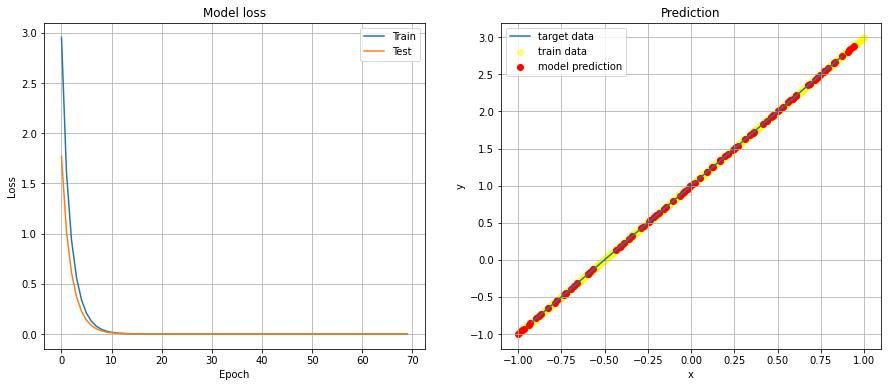

In [31]:
plot_NN(history_0, data_0, model_0)

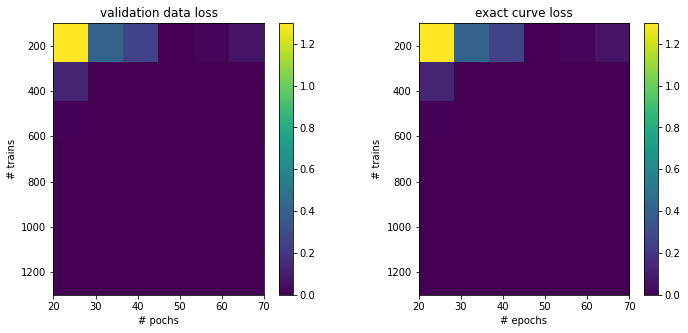

In [32]:
plot_grid(TEST_0)

We see, as expected, a loss decrease for increasing N_trains and N_epochs. For N_trains higher then 200 the regression is extremely precise for almost every value of N_epochs. 
In this case ($\sigma=0$) validation and exact curve losses are the same (the validation data points are exctracted from the exact curve), but this will not be the case for non zero $\sigma$

----------------
## $\sigma=0.1$

In [43]:
best_TEST_results(TEST_01)
L_ec_mean=np.mean(TEST_01["loss_EC"].to_numpy()[0])

best values for different N:train
N_train=   N_epoch    loss validation data  loss exact curve     
100        40         0.019954904913902283  0.010525033809244633 
300        70         0.007747607305645943  0.0004760298761539161
500        70         0.008545050397515297  1.1144774362037424e-05
700        50         0.006054649129509926  2.285679329361301e-05
900        60         0.008058403618633747  1.9543771486496553e-05
1100       30         0.007543604820966721  4.307332346797921e-06
1300       60         0.007441435009241104  2.0608622435247526e-05


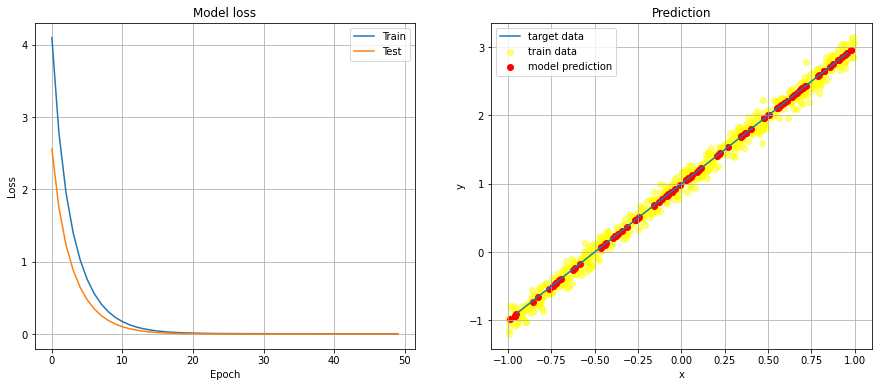

In [34]:
plot_NN(history_01, data_01, model_01)

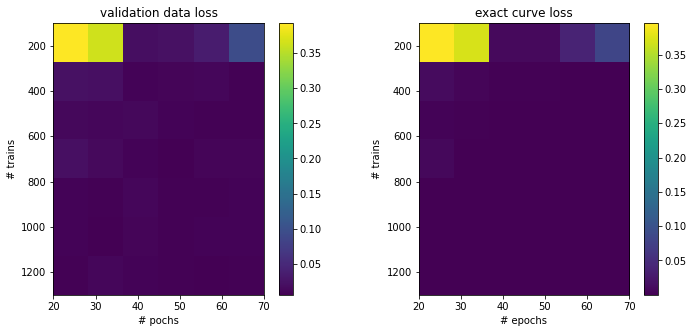

In [35]:
plot_grid(TEST_01)

As for the case of $\sigma=0$ the losses decrease for increasing N_trains and N_epochs, even though in this case are higher.
Note that validation loss and exact curve loss are not the same, as $σ$ increases validation loss will increase while, if the neural network is able to make a good regression, the exact curve loss will be lower

--------------------
## $\sigma=0.6$

In [36]:
best_TEST_results(TEST_06)

best values for different N:train
N_train=   N_epoch    loss validation data  loss exact curve     
100        60         0.40049275755882263   0.04492567852139473  
300        30         0.2747061252593994    0.01966388151049614  
500        60         0.19661064445972443   0.00246113957837224  
700        40         0.3019743263721466    0.0003976640000473708
900        60         0.19167254865169525   0.0017873016186058521
1100       40         0.25267305970191956   1.2488363609008957e-05
1300       50         0.24838897585868835   0.00023214146494865417


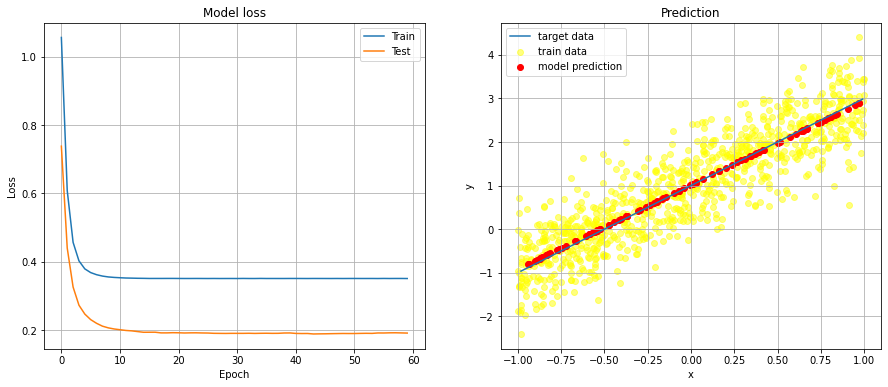

In [37]:
plot_NN(history_06, data_06, model_06)

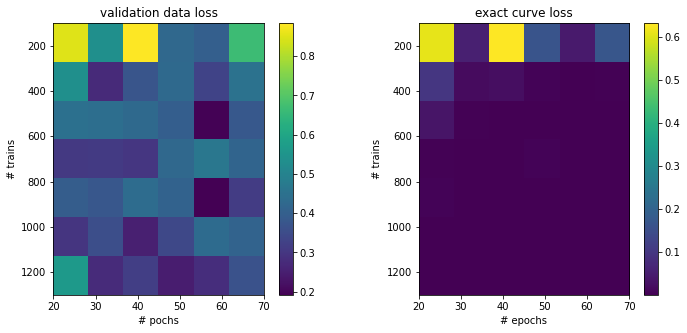

In [39]:
plot_grid(TEST_06)

While for the exact curve loss there still is a clear decrease for increasing N_train and N_epochs, it's not so evident for the validation loss. Validation loss is now sensible to chance since the data are more spreaded, while exact curve loss is still precise since regression continues to work well

-----------------
## $\sigma=1$

In [40]:
best_TEST_results(TEST_1)

best values for different N:train
N_train=   N_epoch    loss validation data  loss exact curve     
100        60         0.9523888230323792    0.03541150689125061  
300        20         0.6766916513442993    0.013763416558504105 
500        60         0.6378291845321655    0.01378514152020216  
700        30         0.8181219696998596    0.002262171357870102 
900        20         0.8133577108383179    0.0006394425290636718
1100       70         0.7938984036445618    1.363529827358434e-05
1300       30         0.8151877522468567    0.00011856367927975953


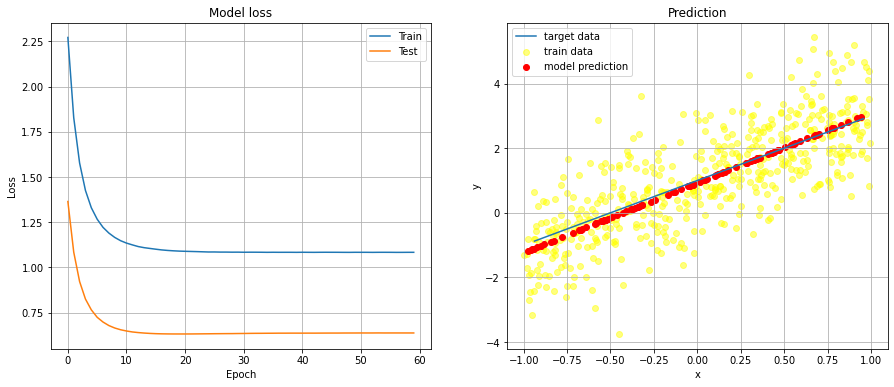

In [41]:
plot_NN(history_1, data_1, model_1)

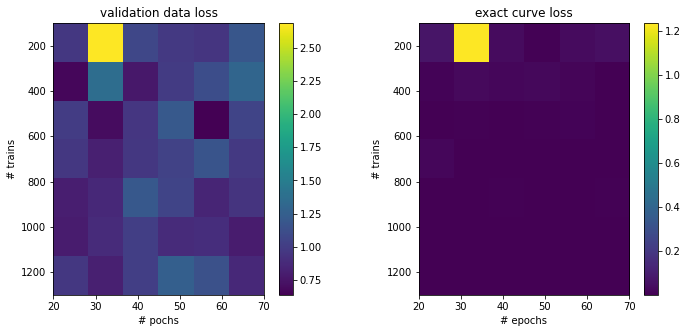

In [42]:
plot_grid(TEST_1)

The considerations are the same as above. The only difference is that losses are higher as shown by the data in the table above

---------
Let's try to understend the apparent bias between training loss and validation loss

In [ ]:
N_t=5000
N_e=50
data_check, history_check, l_check, l_ec_check,model_check=NN_test(N_t, N_e, sigmas[3])

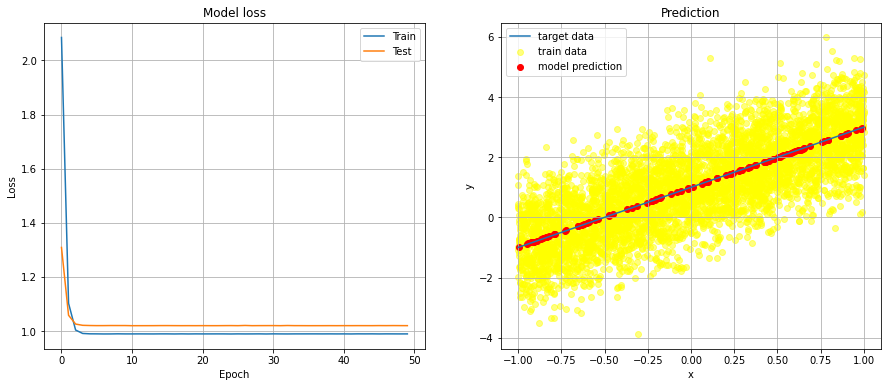

In [9]:
plot_NN(history_check, data_check, model_check)

Increasing the number of points for both training and validation reduces the bias (even inverting it). This effect doesn't seem to have any particular significance but chance. It happens because the data points are random and because in the cases above there is a significant difference between the number of validation points and the number of training points. In the limit of infinite data points the two losses should coincide

---------
-----------
--------

Let's see now how changes validation for different N_train and sigma

In [11]:
def losses_N_train(sigma):
  i=0
  losses_EC=np.zeros(len(N_trains))
  losses_VD=np.zeros(len(N_trains))

  for N_train in N_trains:
    data,history, test_loss, loss_ec, model=NN_test(N_train, N_epoch, sigma)
    losses_VD[i]=test_loss
    losses_EC[i]=loss_ec
    i=i+1
  
  return losses_VD,losses_EC 

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3]


### Different N_trains and $\sigma$

In [ ]:
N_trains=np.arange(10,200, 10, dtype=int)
N_epoch=30
sigmas=np.arange(0.1,1.5,0.2)
print(N_trains)
print(sigmas)

In [ ]:
Loss_VD=np.zeros((len(sigmas),len(N_trains)))
Loss_EC=np.zeros((len(sigmas),len(N_trains)))
i=0
for sigma in sigmas:
  Loss_VD[i],Loss_EC[i]=losses_N_train(sigma) 
  i=i+1

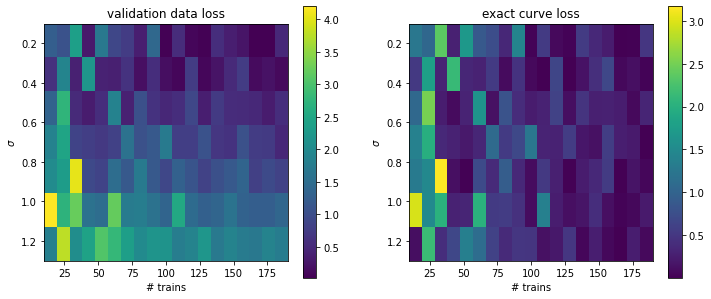

In [17]:
plt.figure(figsize=(12,5))
extent = np.min(N_trains), np.max(N_trains), np.max(sigmas), np.min(sigmas)

plt.subplot(121)
plt.imshow(Loss_VD, extent=extent,aspect= np.max(N_trains)/np.max(sigmas))
plt.title("validation data loss")
plt.xlabel("# trains")
plt.ylabel(f"$\sigma$")
plt.colorbar()

plt.subplot(122)
plt.imshow(Loss_EC, extent=extent,aspect= np.max(N_trains)/np.max(sigmas))
plt.title("exact curve loss")
plt.xlabel("# trains")
plt.ylabel(f"$\sigma$")
plt.colorbar()
plt.show()

As before is seen that the validation loss is higher for low values of N_trains and high values of $\sigma$ and decreases as $\sigma$ gets lower or N_trains gets higher, while exact curve loss seems to be dependent only on the number of trainings: for low N_trains the loss is high for every $\sigma$ and reduces as N_trains increases, wich is consistent with what we found earlier

-----
